# Team Analysis
==========================================================================================

### Thinking
* Players on better teams will play with better players and therefore will perform better
    * Opponents will not be able to focus in on one specific player
* Playing on a team with good defense will only for more offensive snaps
* A good team plays to its strengths: good players will get the ball more
    * Having a smart offensive coordinator or head coach that has a playbook that involves their best players is ideal
* However, a good team may simply just have good players
    * This means that sometimes, your player will perform well regardless of team: they are simply effective 
    * In addition, there is only one ball: stats cannot be shared
        * Playing on a poor team would allow one great player to take in all the stats
    * Does playing on a good team improve or decrease your fantasy production?
    * In reality, this would mainly apply to teams with multiple superstars
   
==========================================================================================
### Data Collection
* Data is available from 2016-2021 (2022, but I don't want to include that data)
* Players have their stats available in this same time period, but advanced stats and defensive aren't tracked until 2018
    * Therefore, I will exclude looking at advanced stats in general in the first bit
    
==========================================================================================
### Method of Analysis
##### Numbers:
* Will calculate the difference of a player's draft position and final standing and its 
    * For example: a player with an ADP (Average Draft Position) of RB12 but finishes the year as the RB5 would be +7
        * Flipping the ADP and Finish would be a -7 rating
        * However, finishing at RB5 from ADP12 is more important than finishing RB24 from ADP31
            * The gap in points is simply too large
            
##### Cleaning + Preparing
* Bring in the data and store in pandas dataframes
    * Need to bring in:
        * ADP (2016-2021Just Overall)
        * Final Seasonal Numbers
        * RedZone Passing, Receiving, Rushing
        * TeamOffense:
            * Conversions
            * Drive averages
            * Passing Offense
            * Rushing Offense
            * Scoring Offense
* Create a Hashing System to link up team names with their abreviations
* Link up player data (Player Team -> Team scoring/passing/receiving/rushing)
* Divide up players by position for comparison
* Scale the numbers (for SVM)

##### Clustering
* Graph a couple of seemingly import attributes
* See if KMeans or MeanShift can cluster the data into groups, may take a long time

##### Modeling
* Will use a SVM and DecisionTree (Maybe RandomForest) to see if there is any trends
* Test on 2022 Seasonal Data while training on these 5-6 years

In [ ]:
### Selecting data to load into list of pandas dataframes
import numpy as np
import pandas as pd
adp = [] #ADP
rnk = [] #End of Season FantasyRankings
rzp = [] #RedZone Passing
rzru = [] #RedZone Rushing
rzre = [] #RedZone Receiving
convs = [] #Conversions
das = [] #driveAverages
pO = [] #passingOffense
rO = [] #rushingOffense
sO = [] #scoringOffense
tO = [] #teamOffense
for i in range(2016, 2022):
    address = "Data/ADP/FantasyPros_" + str(i) + "_Overall_ADP_Rankings.csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    adp.append(temp)
    address = "Data/FantasyRankings/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    rnk.append(temp)
    address = "Data/PlayerStats/Passing/redZonePassing/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    rzp.append(temp)
    address = "Data/PlayerStats/Rushing/redZoneRushing/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    rzru.append(temp)
    address = "Data/PlayerStats/Receiving/redZoneReceiving/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    rzre.append(temp)
    address = "Data/TeamOffense/conversions/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    convs.append(temp)
    address = "Data/TeamOffense/driveAverages/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    das.append(temp)
    address = "Data/TeamOffense/passingOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    pO.append(temp)
    address = "Data/TeamOffense/rushingOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    rO.append(temp)
    address = "Data/TeamOffense/scoringOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    sO.append(temp)
    address = "Data/TeamOffense/teamOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    tO.append(temp)
teamdata = []
for i in range(0, 6):
    df = pd.merge(convs[i], das[i], left_index=True, right_index=True)
    df = pd.merge(df, pO[i], left_index=True, right_index=True)
    df = pd.merge(df, rO[i], left_index=True, right_index=True)
    df = pd.merge(df, sO[i], left_index=True, right_index=True)
    df = pd.merge(df, tO[i], left_index=True, right_index=True)
    teamdata.append(df)
for i in range(5):
    address = "Data/Merged/" + str(i+ 2017) + ".csv"
    teamdata[i].to_csv(address)
for i in range(6):
    adp[i] = adp[i][['Player', 'POS', 'AVG']]
    rnk[i].set_index('Player')
    rnk[i] = rnk[i].drop(['Unnamed: 0'], axis=1, inplace=True)
for i in range(6):
    rnk[i]['Player'] = rnk[i]['Player'].str.replace('*', '')
    rnk[i]['Player'] = rnk[i]['Player'].str.replace('+', '')
for i in range(6):
    t1 = adp[i].copy(deep=True)
    t2 = rnk[i].copy(deep=True)
    t3 = rzp[i].copy(deep=True)
    t4 = rzru[i].copy(deep=True)
    t5 = rzre[i].copy(deep=True)

    t1 = t1.join(t2, on='Player')
    t1 = t1.join(t3, on='Player', lsuffix='rank', rsuffix='rzpa')
    t1 = t1.join(t4, on='Player', lsuffix='rzpa', rsuffix='rzru')
    t1 = t1.join(t5, on='Player', lsuffix='rzru', rsuffix='rzre')
    t1.fillna(0, inplace=True)
    address = "Data/MergedPlayers/" + str(i+2016) + ".csv"
    t1.to_csv(address)
for i in range(1,6):
    rnk[i].drop(['Linkrzru', '-9999rzru', 'Tmrzre', '-9999rank', 'Tmrzpa', '-9999rzre', 'Link', 'Linkrzpa', '-9999rzpa', 'Linkrzpa', 'Tmrzru', '-9999rank'], axis=1, inplace=True)
    rnk[i]['POS'] = rnk[i]['POS'].astype('string')
    rnk[i]['Tmrank'] = rnk[i]['Tmrank'].astype('string')
    rnk[i]['FantPos'] = rnk[i]['FantPos'].astype('string')
    rnk[i]['%Tgt'] = rnk[i]['%Tgt'].astype("string")
    rnk[i]['%Tgt'] = rnk[i]['%Tgt'].str.replace('%', '')
    rnk[i]['%Tgt'] = rnk[i]['%Tgt'].astype(float)
    rnk[i]['%Tgt.1'] = rnk[i]['%Tgt.1'].astype("string")
    rnk[i]['%Tgt.1'] = rnk[i]['%Tgt.1'].str.replace('%', '')
    rnk[i]['%Tgt.1'] = rnk[i]['%Tgt.1'].astype(float)
    
    rnk[i]['Ctch%'] = rnk[i]['Ctch%'].astype("string")
    rnk[i]['Ctch%'] = rnk[i]['Ctch%'].str.replace('%', '')
    rnk[i]['Ctch%'] = rnk[i]['Ctch%'].astype(float)
    rnk[i]['Ctch%.1'] = rnk[i]['Ctch%.1'].astype("string")
    rnk[i]['Ctch%.1'] = rnk[i]['Ctch%.1'].str.replace('%', '')
    rnk[i]['Ctch%.1'] = rnk[i]['Ctch%.1'].astype(float)
    rnk[i]['%Rush.2'] = rnk[i]['%Rush.2'].astype("string")
    rnk[i]['%Rush.2'] = rnk[i]['%Rush.2'].str.replace('%', '')
    rnk[i]['%Rush.2'] = rnk[i]['%Rush.2'].astype(float)
    rnk[i]['%Rush.1'] = rnk[i]['%Rush.1'].astype("string")
    rnk[i]['%Rush.1'] = rnk[i]['%Rush.1'].str.replace('%', '')
    rnk[i]['%Rush.1'] = rnk[i]['%Rush.1'].astype(float)
    rnk[i]['%Rush'] = rnk[i]['%Rush'].astype("string")
    rnk[i]['%Rush'] = rnk[i]['%Rush'].str.replace('%', '')
    rnk[i]['%Rush'] = rnk[i]['%Rush'].astype(float)
for i in range(6):
    team[i]['3D%'] = team[i]['3D%'].astype("string")
    team[i]['3D%'] = team[i]['3D%'].str.replace('%', '')
    team[i]['3D%'] = team[i]['3D%'].astype(float)
    
    team[i]['4D%'] = team[i]['4D%'].astype("string")
    team[i]['4D%'] = team[i]['4D%'].str.replace('%', '')
    team[i]['4D%'] = team[i]['4D%'].astype(float)
    
    team[i]['RZPct'] = team[i]['RZPct'].astype("string")
    team[i]['RZPct'] = team[i]['RZPct'].str.replace('%', '')
    team[i]['RZPct'] = team[i]['RZPct'].astype(float)
    
    team[i]['Start'] = team[i]['Start'].astype("string")
    team[i]['Start'] = team[i]['Start'].str.replace('Own ', '')
    team[i]['Start'] = team[i]['Start'].astype(float)
    
    team[i]['Time'] = team[i]['Time'].astype('string')
    team[i]['Time'] = team[i]['Time'].str.replace(':','.')
    team[i]['Time'] = team[i]['Time'].astype(float)
    
    address = "Data/Merged/" + str(i+2016) + ".csv"
    team[i].to_csv(address)
    
def hasher(item):
    return namesHash1[item]

for i in range(4, 6):
    rnk[i]['Tmrank'] = rnk[i]['Tmrank'].to_frame(name='league').applymap(hasher)
COMPLETE = []
for i in range(6):
    t1 = teams[i].copy(deep=True)
    r1 = rnk[i].copy(deep=True)
    df = pd.DataFrame(r1, columns= ['Tmrank_PLAYERS'])
    columns = []
    for i in range(len(t1.columns)):
        empt = []
        for j in range(len(r1)):
            team = df.iloc[j]['Tmrank_PLAYERS']
            if str(team) == "0":
                empt.append(0)
            else:
                empt.append(t1.loc[team][i])
        columns.append(empt)
    for i in range(len(t1.columns)):
        name = t1.columns[i]
        r1.loc[:,name] = columns[i]
    COMPLETE.append(r1)


In [107]:
# Creating a set of the teams
# Due to moving of team and team name changes, this is not as simple as it would seem
namesHash = {"DET": "Detroit Lions",
"GNB": "Green Bay Packers",
"MIN": "Minnesota Vikings",
"JAX": "Jacksonville Jaguars",
"LVR": "Las Vegas Raiders",
"PHI": "Philadelphia Eagles",
"NOR": "New Orleans Saints",
"SFO": "San Francisco 49ers",
"HOU": "Houston Texans",
"MIA": "Miami Dolphins",
"PIT": "Pittsburgh Steelers",
"SEA": "Seattle Seahawks",
"CHI": "Chicago Bears",
"IND": "Indianapolis Colts",
"TEN": "Tennessee Titans",
"NYJ": "New York Jets",
"LAR": "Los Angeles Rams",
"DAL": "Dallas Cowboys",
"2TM": "",
"KAN": "Kansas City Chiefs",
"SDG": "San Diego Chargers",
"3TM": "",
"LAC": "Los Angeles Chargers",
"BUF": "Buffalo Bills",
"BAL": "Baltimore Ravens",
"ATL": "Atlanta Falcons",
"OAK": "Oakland Raiders",
"DEN": "Denver Broncos",
"CLE": "Cleveland Browns",
"NWE": "New England Patriots",
"TAM": "Tampa Bay Buccaneers",
"NYG": "New York Giants",
"CIN": "Cincinnati Bengals",
"ARI": "Arizona Cardinals",
"WAS": "Washington Redskins",
"CAR": "Carolina Panthers",}    
namesHash1 = {"DET": "Detroit Lions",
"GNB": "Green Bay Packers",
"MIN": "Minnesota Vikings",
"JAX": "Jacksonville Jaguars",
"LVR": "Las Vegas Raiders",
"PHI": "Philadelphia Eagles",
"NOR": "New Orleans Saints",
"SFO": "San Francisco 49ers",
"HOU": "Houston Texans",
"MIA": "Miami Dolphins",
"PIT": "Pittsburgh Steelers",
"SEA": "Seattle Seahawks",
"CHI": "Chicago Bears",
"IND": "Indianapolis Colts",
"TEN": "Tennessee Titans",
"NYJ": "New York Jets",
"LAR": "Los Angeles Rams",
"DAL": "Dallas Cowboys",
"2TM": "",
"KAN": "Kansas City Chiefs",
"SDG": "San Diego Chargers",
"3TM": "",
"LAC": "Los Angeles Chargers",
"BUF": "Buffalo Bills",
"BAL": "Baltimore Ravens",
"ATL": "Atlanta Falcons",
"OAK": "Oakland Raiders",
"DEN": "Denver Broncos",
"CLE": "Cleveland Browns",
"NWE": "New England Patriots",
"TAM": "Tampa Bay Buccaneers",
"NYG": "New York Giants",
"CIN": "Cincinnati Bengals",
"ARI": "Arizona Cardinals",
"WAS": "Washington Football Team",
"CAR": "Carolina Panthers",} 

In [224]:
import numpy as np
import pandas as pd

rnk = []
teams = []

for i in range(2016, 2022):
    address = "Data/Merged/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    temp.columns = [str(col) + '_TEAMS' for col in temp.columns]
    teams.append(temp)
    address = "Data/MergedPlayers/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    temp['POS'] = temp['POS'].astype("string")
    temp['Tmrank'] = temp['Tmrank'].astype("string")
    temp['FantPos'] = temp['FantPos'].astype("string")
    temp = temp[temp['Tmrank'] !="0"]
    temp.columns = [str(col) + '_PLAYERS' for col in temp.columns]
    rnk.append(temp)

In [226]:

for i in range(6):
    address = "Data/TEST/" + str(i) + ".csv"
    COMPLETE[i].to_csv(address)

In [227]:
full = pd.concat(COMPLETE, ignore_index=True)

In [232]:
full.columns

Index(['Rank_PLAYERS', 'POS_PLAYERS', 'AVG_PLAYERS', 'Rk_PLAYERS',
       'Tmrank_PLAYERS', 'FantPos_PLAYERS', 'Age_PLAYERS', 'G_PLAYERS',
       'GS_PLAYERS', 'Cmprank_PLAYERS',
       ...
       'Y/P_TEAMS', 'TO_TEAMS', 'FL_TEAMS', '1stD_TEAMS', 'Pen_TEAMS',
       'Yds.p_TEAMS', '1stPy_TEAMS', 'Sc%_to_TEAMS', 'TO%_to_TEAMS',
       'EXP_TEAMS'],
      dtype='object', length=158)

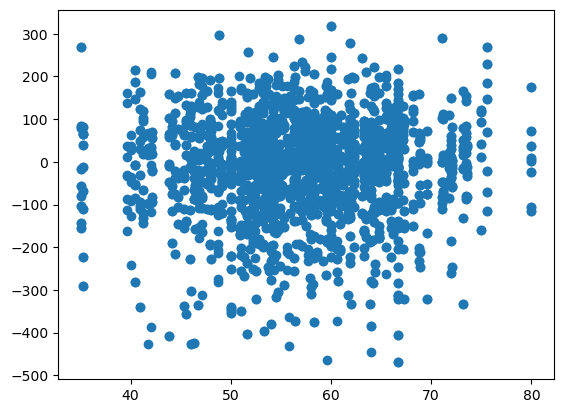

In [235]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
plt.scatter(full['RZPct_TEAMS'], full['Difference_PLAYERS'])
plt.show()

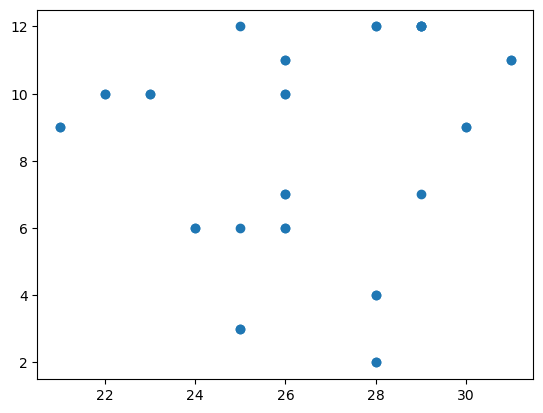

26.37142857142857
2.755590192848779


In [263]:
x = full.loc[(full['Rk_PLAYERS'] < 13) & (full['FantPos_PLAYERS'] == 'WR')]['Age_PLAYERS']
y = full.loc[(full['Rk_PLAYERS'] < 13) & (full['FantPos_PLAYERS'] == 'WR')]['Rk_PLAYERS']
plt.scatter(x, y)
plt.show()
print(x.mean())
print(x.std())

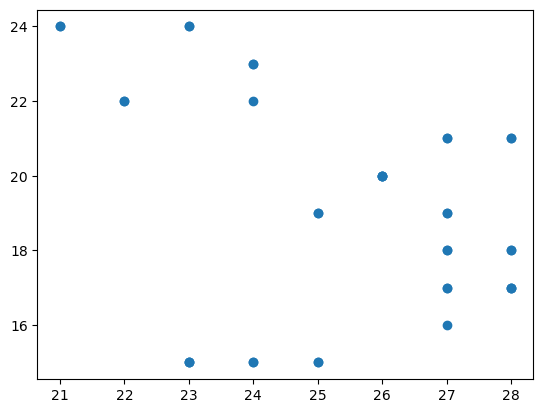

25.36842105263158
2.1613440842114016


In [264]:
x = full.loc[(full['Rk_PLAYERS'] > 12) & (full['Rk_PLAYERS'] <= 24) & (full['FantPos_PLAYERS'] == 'WR')]['Age_PLAYERS']
y = full.loc[(full['Rk_PLAYERS'] > 12) & (full['Rk_PLAYERS'] <= 24) & (full['FantPos_PLAYERS'] == 'WR')]['Rk_PLAYERS']
plt.scatter(x, y)
plt.show()
print(x.mean())
print(x.std())